In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tkinter import Tcl
import sys
import os
sys.path.append("/home/miguel/Documents/10_projects/reGrainable/data/csv")
sys.path.append("/home/miguel/Documents/10_projects/reGrainable/utils")
from scipy.ndimage import gaussian_filter1d

from scipy.stats import pearsonr, linregress

from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import LogLocator
%matplotlib inline 

import plots

In [2]:
df_CFA = pd.read_csv("../data/csv/CFA_interpolated/CFA_interpolated.csv")

df_CFA

,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
0,2002.551,1.044638,35.386801,55.215085,12756.954682,1.126816,64.802555,NaN,71186.178182
1,2002.552,1.053359,34.908770,55.349388,12533.003895,1.146882,64.671126,NaN,71186.356364
2,2002.553,1.062309,34.420666,55.475033,12295.928952,1.166981,64.537724,NaN,71186.534545
3,2002.554,1.071514,33.925007,55.593180,12045.890426,1.187068,64.403140,NaN,71186.712727
4,2002.555,1.081003,33.424313,55.704991,11783.048888,1.207099,64.268160,NaN,71186.890909
...,...,...,...,...,...,...,...,...,...
24745,2027.296,0.764100,17.984200,36.535192,4456.137400,2.680900,58.051600,NaN,76173.490909
24746,2027.297,0.753100,18.111000,36.221190,4473.086900,2.594200,58.027900,NaN,76173.618182
24747,2027.298,0.742600,18.205200,35.845437,4745.025200,2.512500,57.892200,NaN,76173.745455
24748,2027.299,0.735600,18.253500,35.541933,5076.162400,2.452800,57.730200,NaN,76173.872727


In [3]:
# # this is a fix for the cell below using pathlib instead and some adjustments. Not to use for  now

# from pathlib import Path
# import pandas as pd

# resolution_mm = { "10": 10, ... }  # Definitions as before
# df_sizes = {}
# file_path = Path("../data/csv/grain_sizes_depth/")

# for key, value in resolution_mm.items():
#     print(key)
#     path = file_path / f"grain_data_interp_{value}mm.csv"
#     try:
#         df_sizes[key] = pd.read_csv(path)
#     except FileNotFoundError:
#         print(f"File not found: {path}")

# # Accessing the DataFrame for resolution "10"
# df_sizes["10"].head()

now cell below is to read several csv files with different mm resolution and generates a dictionary with keys to read. I am not going to use it here because I want a single 100mm file

In [4]:
# # Load xLASM
# resolution_mm = {
#     "10": 10,
#     # "7.31": 7.31,
#     # "12.12": 12.12,
#     # "8.8": 8.8,
#     # "8.69": 8.69,
#     # "11.21": 11.21,
#     # "9.09": 9.09,
# }
# df_sizes = {}
# file_path = "../data/csv/grain_sizes_depth/"

# for key in resolution_mm.keys():
#     print(key)
#     path = file_path + "grain_data_interp_{}mm.csv".format(resolution_mm[key])
#     df_sizes[key] = pd.read_csv(path)
# df_sizes[list(df_sizes.keys())[0]].head()

# df_sizes["10"]

In [5]:
# Define the path to your single CSV file
file_path = "/home/miguel/Documents/10_projects/reGrainable/data/csv/grain_sizes_depth/grain_data_interp_100mm.csv"

# Load the CSV file into a DataFrame
df_sizes100 = pd.read_csv(file_path)

# Display the first few rows to verify it's loaded correctly
df_sizes100.head()

,depth[m],equivalent_diameter[px],grain_size[px]
0,2002.553,313.310222,2.679958e+06
1,2002.554,311.255933,2.648215e+06
2,2002.555,310.391733,2.630230e+06
3,2002.556,310.235232,2.621922e+06
4,2002.557,310.851366,2.628481e+06


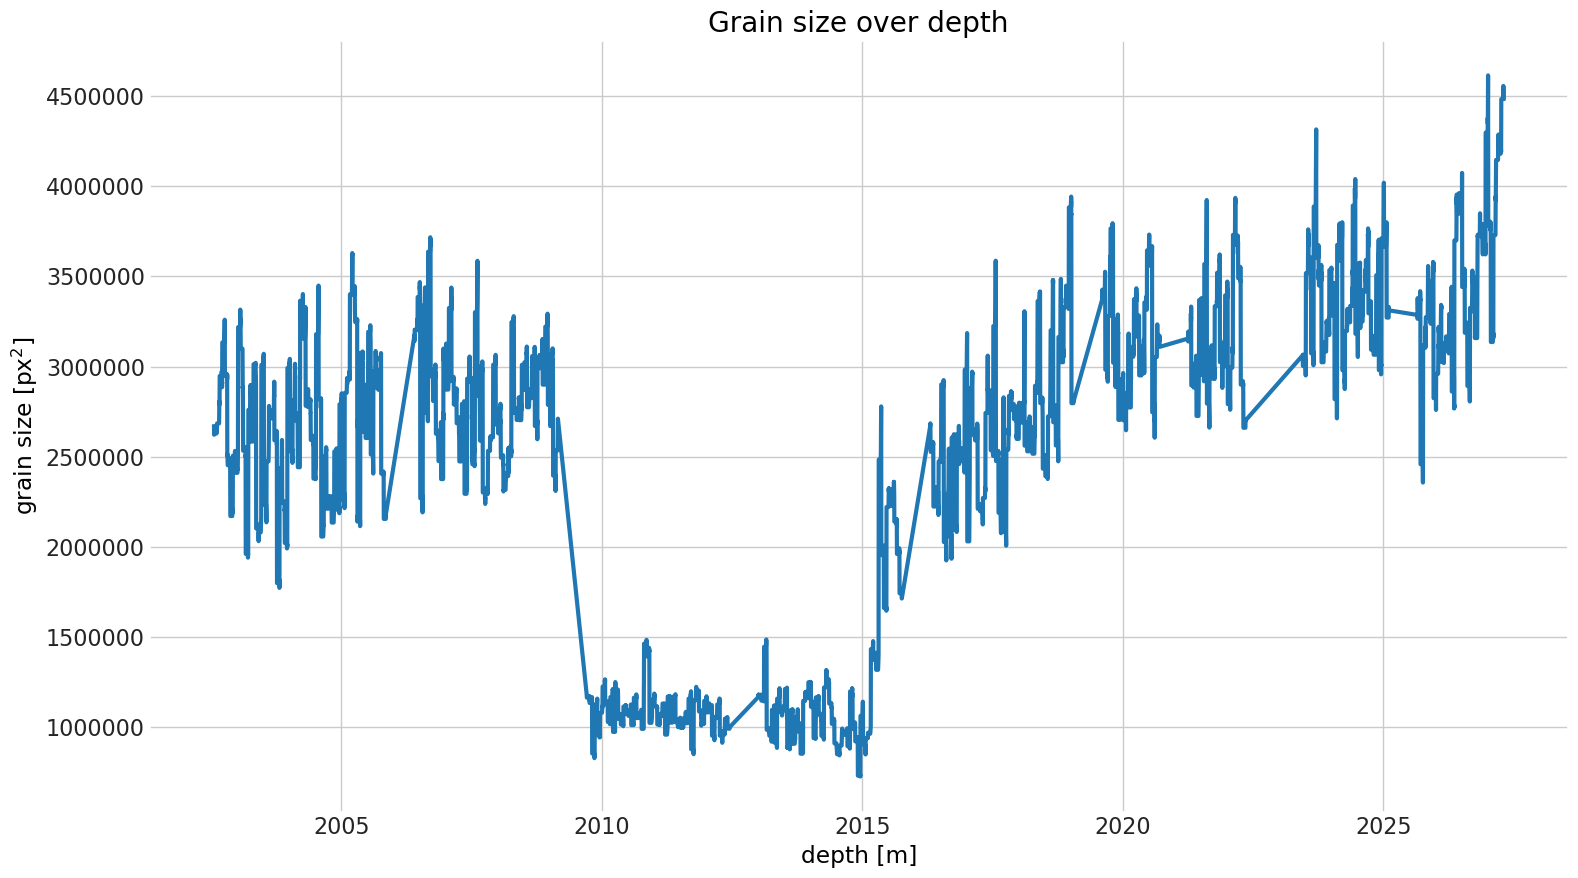

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Plot grain sizes over depth
ax.plot(df_sizes100["depth[m]"], df_sizes100["grain_size[px]"], "-", label="Grain Data")

ax.ticklabel_format(useOffset=False, style="plain")
ax.set(title="Grain size over depth", xlabel="depth [m]", ylabel="grain size [px$^2$]")

fig.tight_layout()
plt.show()

## Preparing dataframes to merge

In [7]:
# Assuming CFA_df["10"] and df_sizes["10"] are your data sources
# CFA_data = CFA_df["10"].drop(
CFA_data = df_CFA.drop(
    ["H2O2 (ng/g)", "age (yr b2k)"], axis=1
)  # removing columns H2O2 and age
GS_data = df_sizes100.drop(
    "equivalent_diameter[px]", axis=1
)  # Grain size data at 10mm resolution

# Assuming grain_size_Data is your grain size DataFrame
GS_data.rename(columns={"depth[m]": "depth_m"}, inplace=True)

In [8]:
CFA_data["Depth top (m)"] = CFA_data["Depth top (m)"].round(3)
# Example of adding a very small number before rounding
GS_data["depth_m"] = (GS_data["depth_m"] + 0.00005).round(3)
GS_data["depth_m"] = GS_data["depth_m"].round(3)

In [9]:
print(f"CFA_data Depth Information:")
total_entries_cfa = CFA_data["Depth top (m)"].shape[0]
unique_entries_cfa = CFA_data["Depth top (m)"].nunique()
print(f"Total depth entries: {total_entries_cfa}")
print(f"Unique depth entries: {unique_entries_cfa}")
if total_entries_cfa != unique_entries_cfa:
    print(
        f"Duplicate depths found in CFA_data: {total_entries_cfa - unique_entries_cfa}"
    )
else:
    print("All depth entries are unique in CFA_data.")

CFA_data Depth Information:
Total depth entries: 24750
Unique depth entries: 24750
All depth entries are unique in CFA_data.


In [10]:
print(f"\nGS_data Depth Information:")
total_entries_gs = GS_data["depth_m"].shape[0]
unique_entries_gs = GS_data["depth_m"].nunique()
print(f"Total depth entries: {total_entries_gs}")
print(f"Unique depth entries: {unique_entries_gs}")
if total_entries_gs != unique_entries_gs:
    print(f"Duplicate depths found in GS_data: {total_entries_gs - unique_entries_gs}")
else:
    print("All depth entries are unique in GS_data.")


GS_data Depth Information:
Total depth entries: 19831
Unique depth entries: 19831
All depth entries are unique in GS_data.


In [11]:
# Merging on depth, assuming df_CFA has been prepared with the correct column name for depth
merged_df = pd.merge(
    CFA_data, GS_data, left_on="Depth top (m)", right_on="depth_m", how="inner"
)

merged_df.drop("depth_m", axis=1, inplace=True)

## Exploratory Data analysis EDA

In [12]:
# List of some CFA parameters
parameters = [
    "Cond (mikroS/cm)",
    "Na+ (ng/g)",
    "Ca++ (ng/g)",
    "Dust (#/mL) [SD>1.0]",
    "NH4+ (ng/g)",
    "NO3- (ng/g)",
]

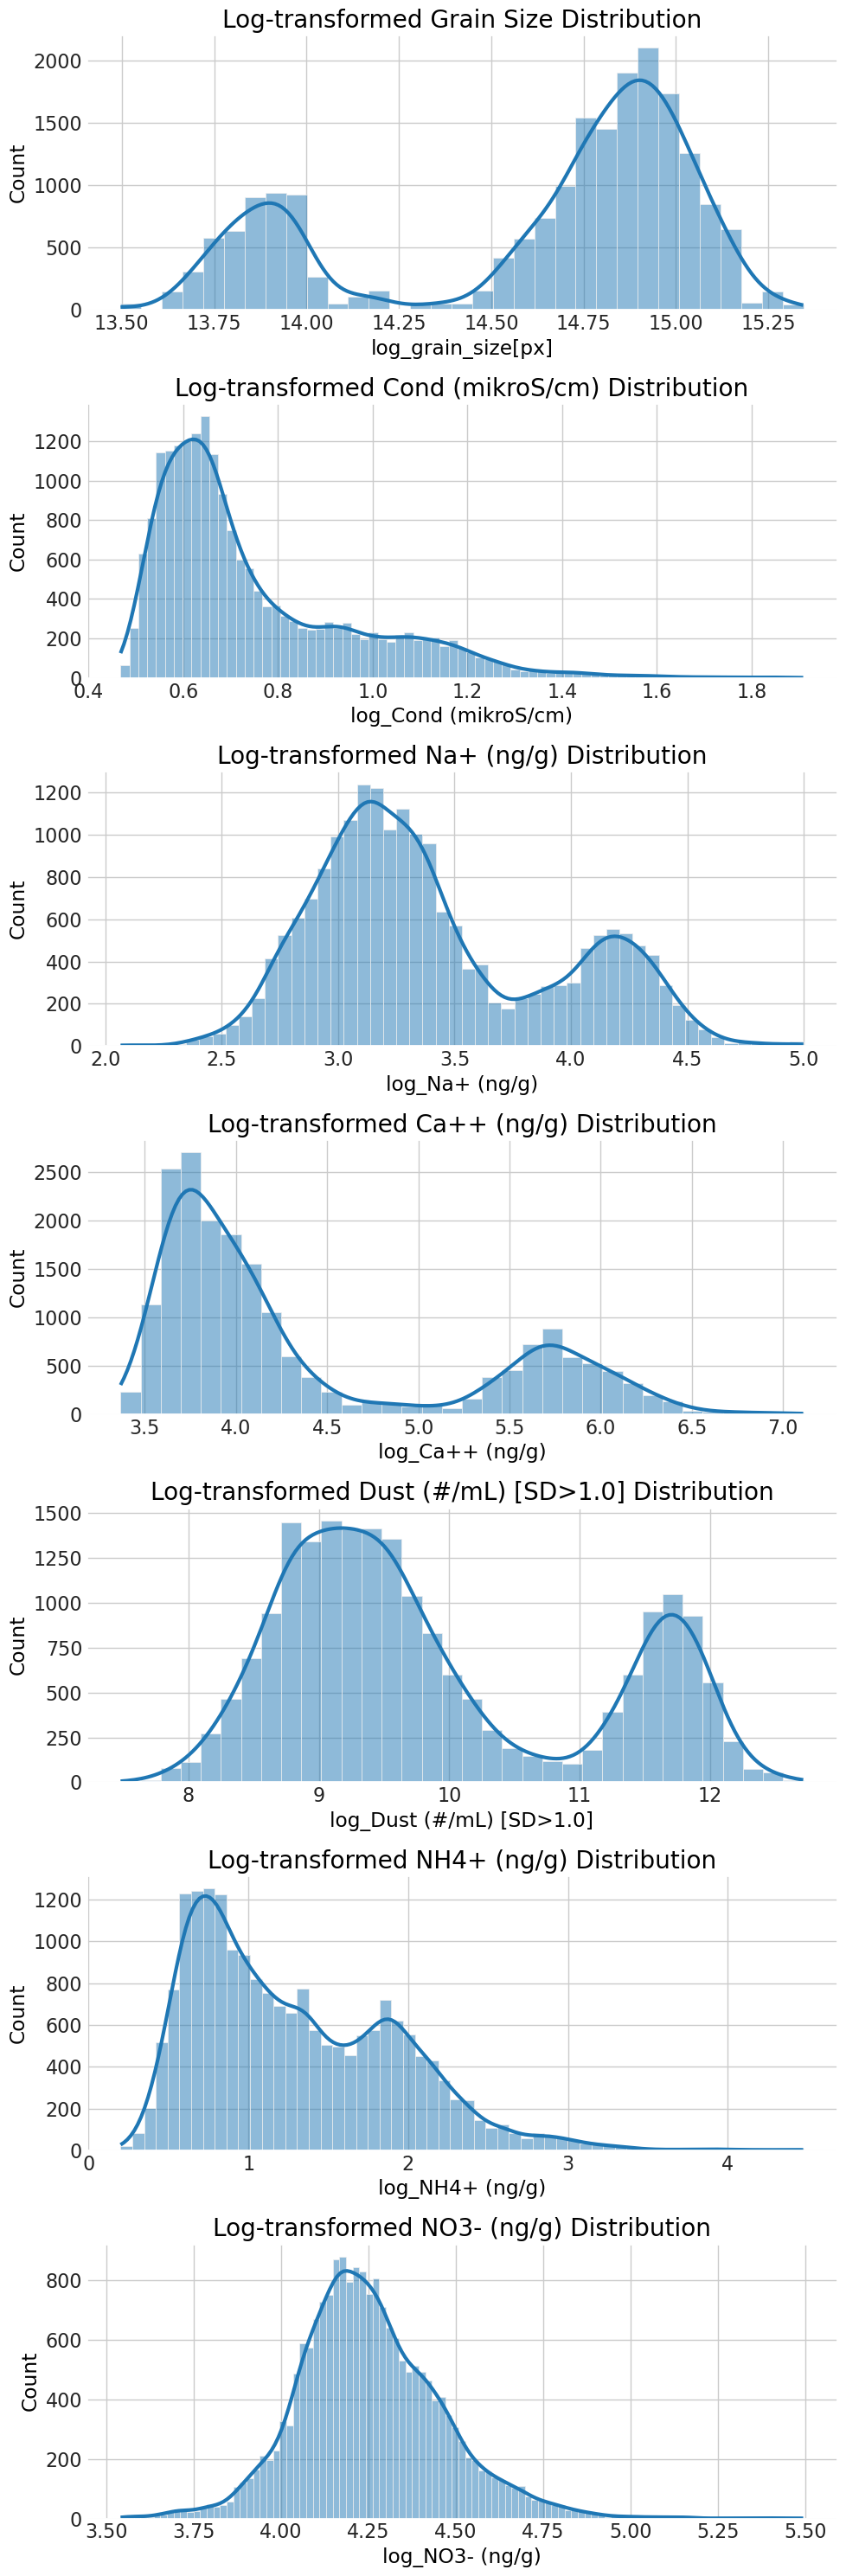

In [13]:
# Apply log transformation to all specified parameters and grain size
for param in parameters + ["grain_size[px]"]:
    merged_df[f"log_{param}"] = np.log1p(merged_df[param])

# Plotting distributions of log-transformed CFA parameters and grain size
fig, axes = plt.subplots(len(parameters) + 1, 1, figsize=(10, 5 * len(parameters)))

# Grain size distribution
sns.histplot(merged_df["log_grain_size[px]"], kde=True, ax=axes[0])
axes[0].set_title("Log-transformed Grain Size Distribution")

# Distributions of log-transformed CFA parameters
for i, param in enumerate(parameters):
    log_param = f"log_{param}"
    sns.histplot(merged_df[log_param], kde=True, ax=axes[i + 1])
    axes[i + 1].set_title(f"Log-transformed {param} Distribution")

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

# Melt the DataFrame to have long-form data for both original and log-transformed variables
melted_df = pd.melt(
    merged_df,
    id_vars="Depth top (m)",  # This is the identifier variable
    value_vars=parameters
    + [f"log_{param}" for param in parameters]
    + ["grain_size[px]", "log_grain_size[px]"],
    var_name="Parameter",
    value_name="Value",
)

# Add a column to differentiate between original and log-transformed data
melted_df["Transformation"] = melted_df["Parameter"].apply(
    lambda x: "Log" if "log_" in x else "Original"
)

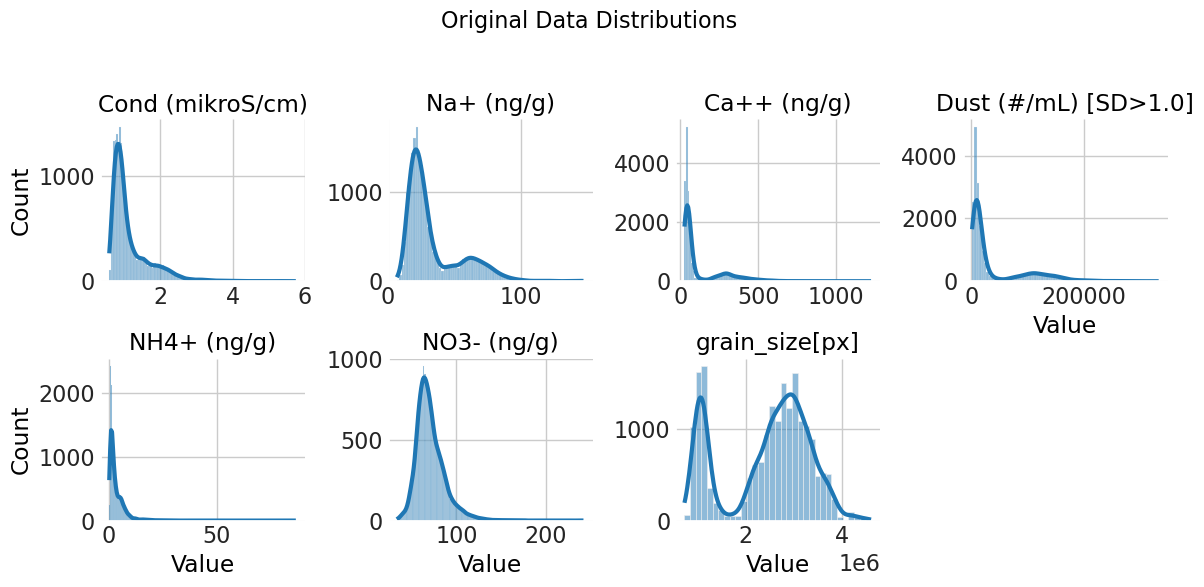

In [15]:
# FacetGrid for the original data distributions
g_original = sns.FacetGrid(
    melted_df[melted_df["Transformation"] == "Original"],
    col="Parameter",
    col_wrap=4,
    sharex=False,
    sharey=False,
)
g_original.map(sns.histplot, "Value", kde=True)
g_original.set_axis_labels("Value", "Count")
g_original.set_titles("{col_name}")
g_original.fig.suptitle("Original Data Distributions", fontsize=16)
g_original.fig.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust layout to make space for the title
# plt.savefig(f"Plots/regression-analysis/original-data-dsitributions", dpi=300)
plt.show()

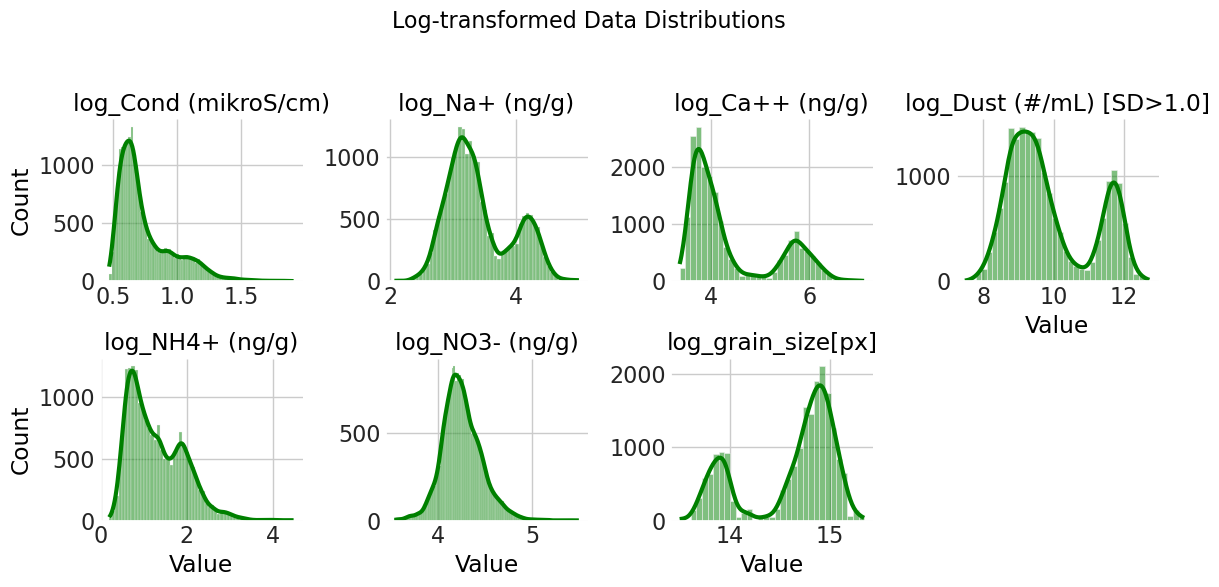

In [16]:
# Choose a color for the log plots
log_color = "green"  # You can set this to your preferred color

# FacetGrid for the log-transformed data distributions with specified color
g_log = sns.FacetGrid(
    melted_df[melted_df["Transformation"] == "Log"],
    col="Parameter",
    col_wrap=4,
    sharex=False,
    sharey=False,
)
g_log.map(sns.histplot, "Value", kde=True, color=log_color)
g_log.set_axis_labels("Value", "Count")
g_log.set_titles("{col_name}")
g_log.fig.suptitle("Log-transformed Data Distributions", fontsize=16)
g_log.fig.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust layout to make space for the title
# plt.savefig(f"Plots/regression-analysis/log-data-dsitributions", dpi=300)
plt.show()

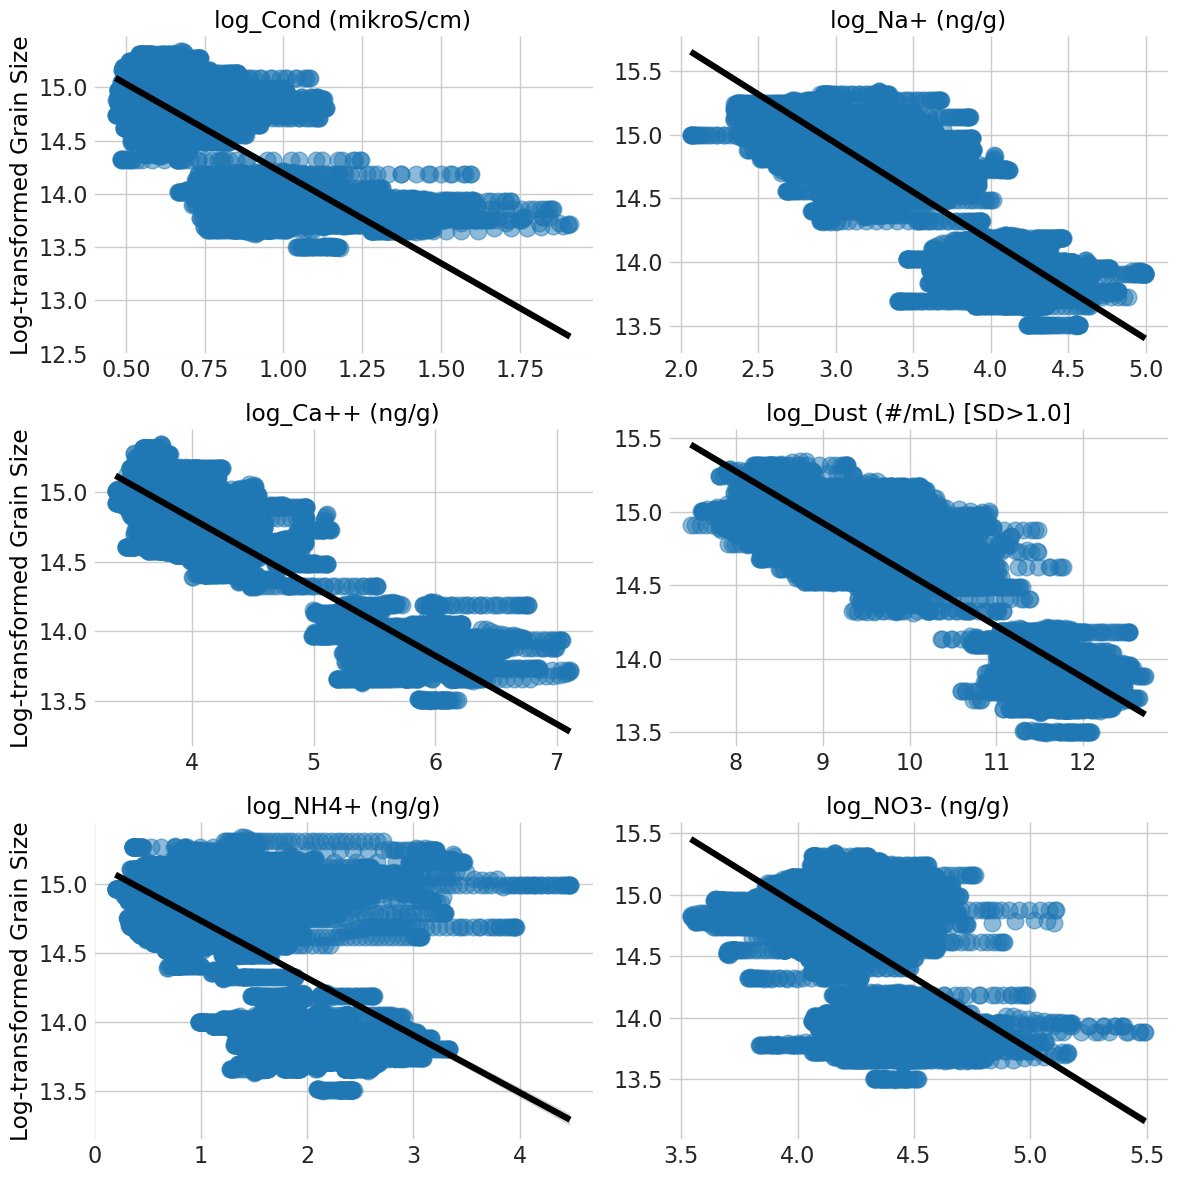

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare a long-form dataframe for sns.FacetGrid
# This involves "melting" your dataframe so each row represents a single observation for a particular variable
long_df = merged_df.melt(
    id_vars=["log_grain_size[px]"],
    value_vars=[
        "log_Cond (mikroS/cm)",
        "log_Na+ (ng/g)",
        "log_Ca++ (ng/g)",
        "log_Dust (#/mL) [SD>1.0]",
        "log_NH4+ (ng/g)",
        "log_NO3- (ng/g)",
    ],
    var_name="Parameter",
    value_name="Value",
)

# Prepare the FacetGrid with the melted dataframe
g = sns.FacetGrid(
    long_df,
    col="Parameter",
    col_wrap=2,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5,
)

# Map sns.regplot to draw the scatter plots and regression lines
g.map(
    sns.regplot,
    "Value",
    "log_grain_size[px]",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "black"},
)

# Adjust the layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Log-transformed Grain Size")
plt.tight_layout()
# plt.savefig(f"Plots/regression-analysis/log-log-linear-reg", dpi=300)

plt.show()

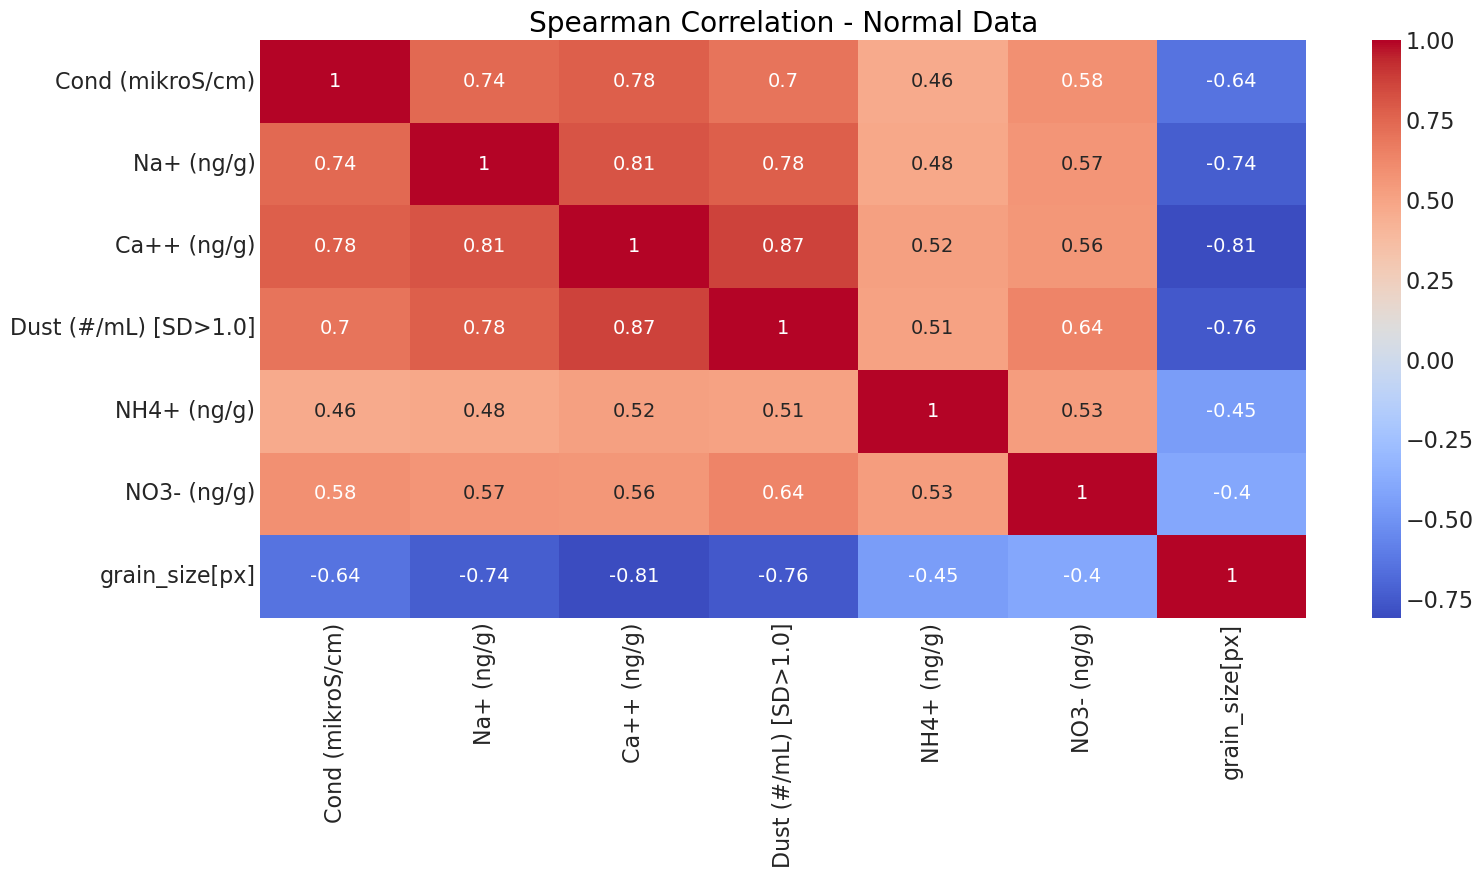

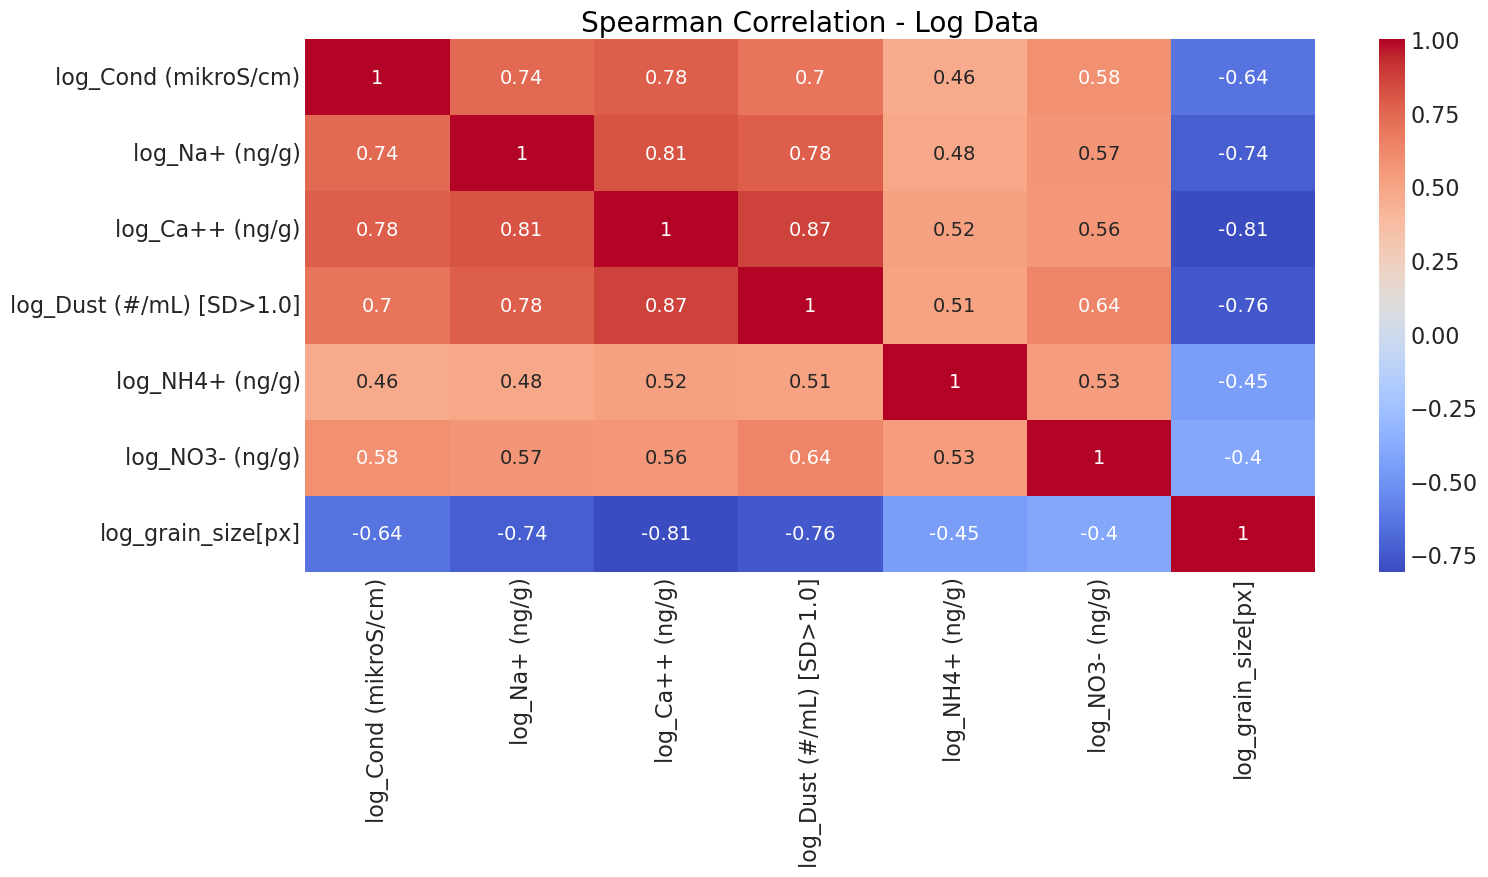

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare your data: Normal and Log-transformed correlation matrices for Spearman
normal_spearman_corr = merged_df[parameters + ["grain_size[px]"]].corr(
    method="spearman"
)
log_spearman_corr = merged_df[
    [f"log_{param}" for param in parameters] + ["log_grain_size[px]"]
].corr(method="spearman")

# Plot Spearman - Normal Data heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(normal_spearman_corr, cmap="coolwarm", cbar=True, annot=True)
plt.title("Spearman Correlation - Normal Data")
plt.tight_layout()
plt.show()

# Plot Spearman - Log Data heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(log_spearman_corr, cmap="coolwarm", cbar=True, annot=True)
plt.title("Spearman Correlation - Log Data")
plt.tight_layout()
plt.show()